In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from collections import Counter

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score

In [2]:
start = time.time()

In [3]:
dev_path = '../DSL2122_january_dataset/development.csv'
eva_path = '../DSL2122_january_dataset/evaluation.csv'

os.path.exists(dev_path), os.path.exists(eva_path)

(True, True)

In [4]:
ds = pd.read_csv(dev_path, low_memory=False)

In [5]:
ds.flag.unique()

array(['NO_QUERY'], dtype=object)

flag feature is the same NO_QUERY for all the records. no relevant information, so i drop it

In [6]:
ds.drop(columns=['flag'], inplace=True)


In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   user       224994 non-null  object
 4   text       224994 non-null  object
dtypes: int64(2), object(3)
memory usage: 8.6+ MB


In [8]:
ds.nunique()

sentiment         2
ids          224716
date         189779
user          10647
text         223106
dtype: int64

In [9]:
ds.drop(columns='text').duplicated().sum()

0

we can observe that the ids feature are almost all unique values for all the records:

224716 different values over 224994 records. are identifiers then we drop them

In [10]:
ds.drop(columns=['ids'], inplace=True)

some users may tend to be optimistic or pessimistic as well in some period of time tweets may tend to be negative or not.
we need to preprocess this data.

first i need to find if the eval dataset present users not present in the dev dataset.

In [11]:
ev_ds = pd.read_csv(eva_path, low_memory=False)

In [12]:
ev_usrs = ev_ds.user.unique()
dev_usrs = ds.user.unique()

In [13]:
print(f'eval_users len: {len(ev_usrs)}\ndev_users len: {len(dev_usrs)}')
# all([sr == SR for sr in eval_sr]))
intersection = set(dev_usrs).intersection(ev_usrs)

print(f'intersection between two set of users have lenght: {len(intersection)}')

eval_users len: 10647
dev_users len: 10647
intersection between two set of users have lenght: 10647


we can assume the same users are present in both dataset, so we can merge the two dataset and handle unique categorical
data for the user feature

In [14]:
dsss = [ds, ev_ds]
full_ds = pd.concat(dsss)

In [15]:
full_ds.drop(columns=['ids', 'flag'], inplace=True)

In [16]:
full_ds['date'] = pd.to_datetime(full_ds['date'])

C:\Users\Ooweey\AppData\Roaming\Python\Python39\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [17]:
full_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299993 entries, 0 to 74998
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sentiment  224994 non-null  float64       
 1   date       299993 non-null  datetime64[ns]
 2   user       299993 non-null  object        
 3   text       299993 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 11.4+ MB


In [18]:
full_ds['month'] = pd.DatetimeIndex(full_ds['date']).month
full_ds['day'] = pd.DatetimeIndex(full_ds['date']).day

In [19]:
full_ds['hour'] = pd.DatetimeIndex(full_ds['date']).hour

In [20]:
full_ds.drop(columns=['date'], inplace=True)

gonna encode hours into fewer ranges of part of the day as morning, afternoon, evening, night

since the year is the same, is not going to be taken in account

In [21]:
'''
morning [5 - 12] -> 0.2
afternoon [13 - 18] -> 0.4
evening [19 - 22] -> 0.6
night [23 - 5] -> 0.8
'''

#TODO: implement the function
def hourToPartOfDay(hour):
    if hour < 4:
        return 0.8
    elif hour < 12:
        return 0.2
    elif hour < 18:
        return 0.4
    elif hour < 23:
        return 0.6
    else:
        return 0.8

full_ds['part_of_day'] = full_ds.hour.apply(lambda x: hourToPartOfDay(x))

In [22]:
mask = full_ds['sentiment'].isna()

In [23]:
# import category_encoders as ce
#
# encod = ce.BinaryEncoder(cols=['user'])
#
# encod.fit_transform(full_ds.user[~mask],full_ds.sentiment[mask] )

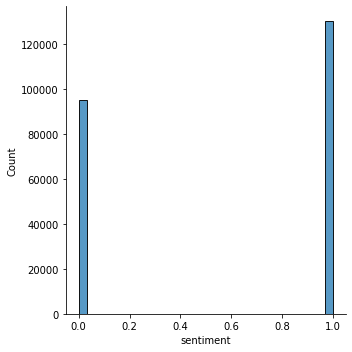

In [24]:

sns.displot(full_ds['sentiment'][~mask])

In [25]:
sents = Counter(full_ds['sentiment'][~mask])

In [26]:
pos_perc = sents[1] / (sents[1]+ sents[0])
neg_perc = sents[0] / (sents[1]+ sents[0])
print(f'positive tweets are: {round(pos_perc*100, 2)}%\nnegative tweets are: {round(neg_perc*100, 2)}%')

positive tweets are: 57.85%
negative tweets are: 42.15%


# <font color=#80bfff> Cleaning Text

#### <font color=#2d862d> Removing tags, punctuation, links and non latin characters

In [27]:
remove_tag = lambda x: re.sub(r'[@]\w+[a-zA-Z0-9] ', '',x)
remove_punct = lambda x: re.sub(r'[^\w\s]', '', x)
remove_links = lambda x: re.sub(r'http\w+[a-zA-Z0-9] ', '', x)
remove_strange_chars = lambda x: x.encode("ascii", "ignore").decode()
full_ds['cl_text'] = full_ds.text.map(remove_tag).map(remove_punct).map(remove_links).map(remove_strange_chars)

In [28]:
from textblob import TextBlob
text = full_ds.cl_text[1]
TextBlob(str(text)).sentiment

Sentiment(polarity=0.0, subjectivity=0.125)

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

full_ds[['polarity', 'subjectivity']] = full_ds.cl_text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [30]:
import nltk
# nltk.download('vader_lexicon')
def get_compound_sentiment(text):
    score = SentimentIntensityAnalyzer().polarity_scores(text)
    return score['compound']

full_ds['comp_sent'] = full_ds.cl_text.apply(get_compound_sentiment)

In [31]:
full_ds['cl_text'] = full_ds.cl_text.apply(str.lower)

#### <font color=#2d862d> Removing stopwords

In [32]:
stopword = nltk.corpus.stopwords.words('english')

def tokenization(text):
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
full_ds['tokenized'] = full_ds.cl_text.apply(lambda x: tokenization(x))

In [33]:
full_ds['no_stop_words'] = full_ds.tokenized.apply(lambda x: remove_stopwords(x))

In [34]:
#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

full_ds['stemmed'] = full_ds.no_stop_words.apply(lambda x: stemming(x))

In [35]:
full_ds.drop(columns=['fin_text_prep'], inplace=True)

KeyError: "['fin_text_prep'] not found in axis"

In [ ]:
def clean_stemmed(text):
    text = [w for w in text if len(w) > 1]
    return text

full_ds['clean_stemmed'] = full_ds['stemmed'].apply(lambda x: clean_stemmed(x))

In [ ]:

full_ds['len_cln_stem'] = full_ds.clean_stemmed.apply(lambda x: len(x))

In [ ]:
from collections import OrderedDict

lenghts = OrderedDict(sorted(Counter(full_ds.len_cln_stem).items()))

In [ ]:
import pprint

pprint.pprint(lenghts)

In [ ]:

eval_lenghts = OrderedDict(sorted(Counter(full_ds[~mask].len_cln_stem).items()))

In [ ]:
pprint.pprint(eval_lenghts)


In [ ]:
eval_lenghts.values().count()

In [ ]:
from sklearn.model_selection import train_test_split
from feature_engine.encoding import PRatioEncoder, RareLabelEncoder

train_df = full_ds[['user', 'sentiment']][~mask]

vars_ = train_df.user.unique()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['sentiment']),
                train_df.drop(columns=['user']), test_size=0.3, random_state=12)

# set up a rare label encoder
rare_encoder = RareLabelEncoder(tol=0.1, n_categories=2, )

rare_encoder.fit(X_train)
# fit and transform data
train_t = rare_encoder.transform(X_train)
test_t = rare_encoder.transform(X_test)

rare_encoder.encoder_dict_

In [ ]:
# set up a weight of evidence encoder
pratio_encoder = PRatioEncoder(encoding_method='ratio', variables=['user'])

# fit the encoder
pratio_encoder.fit(train_t, y_train)

# transform
train_t = pratio_encoder.transform(train_t)
test_t = pratio_encoder.transform(test_t)

pratio_encoder.encoder_dict_